In [89]:
# 数据来自 https://www.kaggle.com/vijayuv/onlineretail

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("classic")
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{ebgaramond}",
    }
)


In [90]:
df = pd.read_csv("OnlineRetail.csv", encoding="cp1252", parse_dates=["InvoiceDate"])
df = df.sort_values(by="InvoiceDate")

len(df)


541909

In [91]:
df.sample(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
88283,543800,22990,COTTON APRON PANTRY DESIGN,2,2011-02-13 11:36:00,4.95,17282.0,United Kingdom
303377,563540,21289,LARGE STRIPES CHOCOLATE GIFT BAG,16,2011-08-17 12:04:00,1.25,12473.0,Germany
478178,577078,20983,12 PENCILS TALL TUBE RED RETROSPOT,1,2011-11-17 15:17:00,1.63,NaN,United Kingdom
68553,541870,21931,JUMBO STORAGE BAG SUKI,1,2011-01-24 09:39:00,4.13,NaN,United Kingdom
103671,545075,48116,DOORMAT MULTICOLOUR STRIPE,2,2011-02-28 09:33:00,7.95,14211.0,United Kingdom
378276,569640,21232,STRAWBERRY CERAMIC TRINKET BOX,60,2011-10-05 12:25:00,1.25,12471.0,Germany
81301,543118,22797,CHEST OF DRAWERS GINGHAM HEART,3,2011-02-03 13:31:00,16.95,13842.0,United Kingdom
421315,572933,23284,DOORMAT KEEP CALM AND COME IN,4,2011-10-27 10:15:00,8.25,13458.0,United Kingdom
536717,581219,35967,FOLK ART METAL STAR T-LIGHT HOLDER,5,2011-12-08 09:28:00,0.83,NaN,United Kingdom
40591,539739,21035,SET/2 RED RETROSPOT TEA TOWELS,1,2010-12-21 15:19:00,5.91,NaN,United Kingdom


In [92]:
# 负数异常数据剔除
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]


In [93]:
# 查看同一股票代码的不同产品描述有多少种
df.groupby("StockCode").Description.nunique().sort_values(ascending=False)


StockCode
23236     4
23196     4
17107D    3
23366     3
23203     3
         ..
22421     1
22422     1
22423     1
22424     1
m         1
Name: Description, Length: 3922, dtype: int64

In [94]:
# 剔除异常产品数据
df = df[
    ~df.StockCode.isin(["POST", "DOT", "M", "AMAZONFEE", "BANK CHARGES", "C2", "S"])
]
len(df)


527794

In [95]:
# 清洗控制变量
df["InvoiceDate"] = pd.to_datetime(df.InvoiceDate)
df["Date"] = pd.to_datetime(df.InvoiceDate.dt.date)
df["revenue"] = df.Quantity * df.UnitPrice


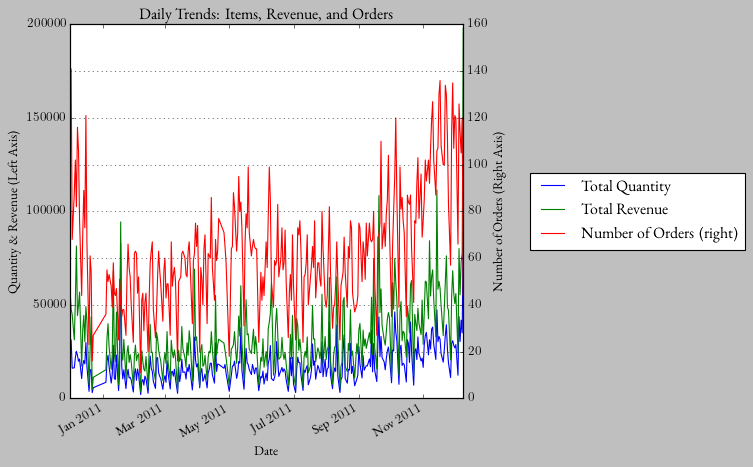

In [96]:
# 1. 先进行聚合 (为了代码整洁，建议先处理数据)
df_plot = df.groupby("Date").agg(
    {"Quantity": "sum", "revenue": "sum", "InvoiceNo": "nunique"}
)

# 2. 重命名列名 (让图例更漂亮)
df_plot.columns = ["Total Quantity", "Total Revenue", "Number of Orders"]

# 3. 绘图 (获取 ax 对象)
# 注意：Pandas 绘图返回的是左轴 (Primary Axes)
ax = df_plot.plot(
    secondary_y="Number of Orders",  # 指定这一列用右轴
    figsize=(10, 6),  # 加宽画布
    title="Daily Trends: Items, Revenue, and Orders",
)

# 4. 设置 Y 轴标签
ax.set_ylabel("Quantity \& Revenue (Left Axis)")
ax.right_ax.set_ylabel(
    "Number of Orders (Right Axis)"
)  # pandas 把右轴藏在 ax.right_ax 里

# =======================================================
# 5. 【核心修改】合并左右轴的图例
# =======================================================
# 获取左轴的句柄和标签
h1, l1 = ax.get_legend_handles_labels()
# 获取右轴的句柄和标签
h2, l2 = ax.right_ax.get_legend_handles_labels()

# 统一在左轴上绘制图例
ax.legend(
    h1 + h2,
    l1 + l2,
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),
)

# =======================================================
# 6. 保存
# =======================================================
plt.grid()  # 加个网格更好看
plt.tight_layout()
plt.savefig(
    "daily_trends_dual_axis.pdf",
)
plt.show()


In [97]:
# 剔除异常偏差值
df = (
    df.assign(
        dNormalPrice=lambda d: d.UnitPrice
        / d.groupby("StockCode").UnitPrice.transform("median")
    )
    .pipe(lambda d: d[(d["dNormalPrice"] > 1.0 / 3) & (d["dNormalPrice"] < 3.0)])
    .drop(columns=["dNormalPrice"])
)


In [98]:
df = df.groupby(["Date", "StockCode", "Country"], as_index=False).agg(
    {"Description": "first", "Quantity": "sum", "revenue": "sum"}
)
df["Description"] = df.groupby("StockCode").Description.transform("first")
df["UnitPrice"] = df["revenue"] / df["Quantity"]


In [99]:
df["Date"] = pd.to_datetime(df["Date"])

df = df.assign(
    month=lambda d: d.Date.dt.month,
    DoM=lambda d: d.Date.dt.day,
    DoW=lambda d: d.Date.dt.weekday,
    stock_age_days=lambda d: (
        d.Date - d.groupby("StockCode").Date.transform("min")
    ).dt.days,
    sku_avg_p=lambda d: d.groupby("StockCode").UnitPrice.transform(
        "median"
    ),  # Stock Keeping Unit Average Price, 即库存量单位平均价格
)


In [100]:
def plot_feature_distributions(df):
    """
    绘制 stock_age_days 和 sku_avg_p 的分布图
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # --- Plot 1: Stock Age Days (产品生命周期) ---
    # 直方图 + 核密度估计 (KDE)
    sns.histplot(
        data=df,
        x="stock_age_days",
        bins=30,
        kde=True,
        edgecolor=None,
        ax=axes[0],
    )
    axes[0].set_title("Distribution of Product Life Cycle")
    axes[0].set_xlabel("Days on Shelf (Stock Age)")
    axes[0].set_ylabel("Frequency")
    # --- Plot 2: SKU Median Price (价格分布) ---
    # 注意：零售价格通常是长尾分布，建议使用 Log Scale 才能看清
    sns.histplot(
        data=df,
        x="sku_avg_p",
        bins=30,
        kde=True,
        log_scale=True,  # 【关键】开启对数坐标，防止长尾挤在一起
        edgecolor=None,
        ax=axes[1],
    )
    axes[1].set_title("Distribution of Baseline Price (Log Scale)")
    axes[1].set_xlabel("Median Price (Log Scale)")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.savefig("feature_distributions.pdf")
    plt.show()



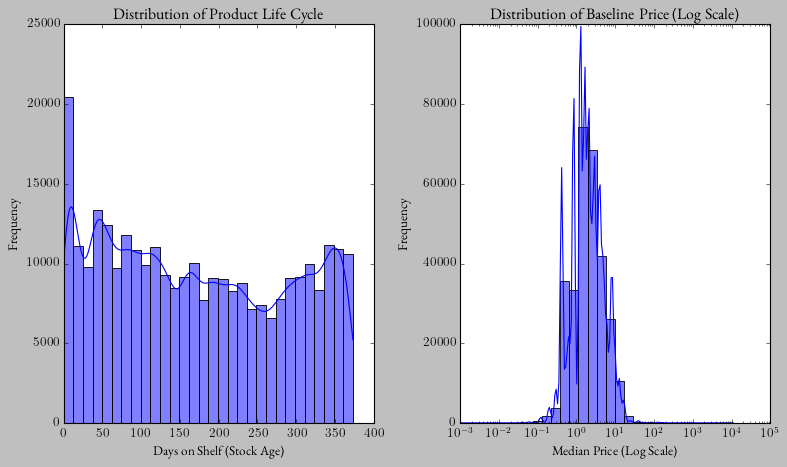

In [101]:
# 调用函数
plot_feature_distributions(df)


In [102]:
df.set_index(["Date", "StockCode", "Country"]).sample(5)


,,,Description,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p
Date,StockCode,Country,,,,,,,,,
2011-08-09,22621,Netherlands,TRADITIONAL KNITTING NANCY,96,139.20,1.45,8,9,1,249,1.65
2011-07-22,22559,United Kingdom,SEASIDE FLYING DISC,4,4.16,1.04,7,22,4,232,1.25
2011-03-25,22652,United Kingdom,TRAVEL SEWING KIT,10,16.50,1.65,3,25,4,114,1.65
2011-01-09,22378,United Kingdom,WALL TIDY RETROSPOT,25,27.50,1.10,1,9,6,39,2.10
2011-01-24,21257,United Kingdom,VICTORIAN SEWING BOX MEDIUM,1,15.79,15.79,1,24,0,54,7.95


In [103]:
df_mdl = df[(df.groupby("StockCode").UnitPrice.transform("std") > 0)]
df_mdl


,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85,12,1,2,0,0.850000
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85,12,1,2,0,0.850000
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85,12,1,2,0,0.850000
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85,12,1,2,0,0.659667
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51,12,1,2,0,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
298221,2011-12-09,90202C,United Kingdom,GREEN ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,367,2.950000
298222,2011-12-09,90202D,United Kingdom,PINK ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,357,2.900000
298223,2011-12-09,90206C,United Kingdom,CRYSTAL DIAMANTE STAR BROOCH,1,4.98,4.98,12,9,4,373,4.980000
298224,2011-12-09,90208,United Kingdom,PAIR OF PINK FLOWER CLUSTER SLIDE,1,2.48,2.48,12,9,4,368,2.480000


In [104]:
# 将单价和数量取log
df_mdl = df_mdl.assign(
    LnP=np.log(df_mdl["UnitPrice"]),
    LnQ=np.log(df_mdl["Quantity"]),
)


In [105]:
# De-meaned

df_mdl["dLnP"] = np.log(df_mdl.UnitPrice) - np.log(
    df_mdl.groupby("StockCode").UnitPrice.transform("mean")
)
df_mdl["dLnQ"] = np.log(df_mdl.Quantity) - np.log(
    df_mdl.groupby("StockCode").Quantity.transform("mean")
)


In [106]:
df_mdl


,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p,LnP,LnQ,dLnP,dLnQ
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85,12,1,2,0,0.850000,-0.162519,3.871201,-0.173158,1.046094
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85,12,1,2,0,0.850000,-0.162519,2.484907,-0.173158,-0.340200
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85,12,1,2,0,0.850000,-0.162519,0.693147,-0.015594,-2.211211
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85,12,1,2,0,0.659667,-0.162519,1.609438,0.257981,-1.615385
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51,12,1,2,0,1.250000,0.920283,0.000000,0.551839,-2.918686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298221,2011-12-09,90202C,United Kingdom,GREEN ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,367,2.950000,1.064711,0.000000,-0.010554,-0.430783
298222,2011-12-09,90202D,United Kingdom,PINK ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,357,2.900000,1.064711,0.000000,-0.005003,-0.693147
298223,2011-12-09,90206C,United Kingdom,CRYSTAL DIAMANTE STAR BROOCH,1,4.98,4.98,12,9,4,373,4.980000,1.605430,0.000000,-0.002490,-0.461346
298224,2011-12-09,90208,United Kingdom,PAIR OF PINK FLOWER CLUSTER SLIDE,1,2.48,2.48,12,9,4,368,2.480000,0.908259,0.000000,-0.007461,-0.414944


In [107]:
# 清洗完毕，数据保存为csv
df_mdl.to_csv("OnlineRetail_clean.csv", index=False)
